In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
WORKING_DIR = os.path.dirname(os.path.abspath(''))
sys.path.insert(1, os.path.join(WORKING_DIR,'LensQuEst'))

In [3]:
from universe import *
from halo_fit import *
from cmb import *
from flat_map import *
from weight import *
from pn_2d import *


In [4]:
print("Map properties")

# number of pixels for the flat map
nX = 400 #1200
nY = 400 #1200

# map dimensions in degrees
sizeX = 10.
sizeY = 10.

# basic map object
baseMap = FlatMap(nX=nX, nY=nY, sizeX=sizeX*np.pi/180., sizeY=sizeY*np.pi/180.)

# multipoles to include in the lensing reconstruction
lMin = 30.; lMax = 3.5e3

# ell bins for power spectra
nBins = 21  # number of bins
lRange = (1., 2.*lMax)  # range for power spectra

Map properties


In [5]:
print("CMB experiment properties")

# Adjust the lMin and lMax to the assumptions of the analysis
# CMB S3 specs
cmb = StageIVCMB(beam=1., noise=1., lMin=lMin, lMaxT=lMax, lMaxP=lMax, atm=False)

# Total power spectrum, for the lens reconstruction
forCtotal = lambda l: cmb.flensedTT(l) + cmb.fdetectorNoise(l)
#
# reinterpolate: gain factor 10 in speed
L = np.logspace(np.log10(lMin/2.), np.log10(2.*lMax), 1001, 10.)
F = np.array(list(map(forCtotal, L)))
cmb.fCtotal = interp1d(L, F, kind='linear', bounds_error=False, fill_value=0.)

CMB experiment properties


In [6]:
print("CMB lensing power spectrum")

u = UnivPlanck15()
halofit = Halofit(u, save=False)
w_cmblens = WeightLensSingle(u, z_source=1100., name="cmblens")
p2d_cmblens = P2dAuto(u, halofit, w_cmblens, save=False)

CMB lensing power spectrum


In [45]:
print("Compute the statistical uncertainty on the reconstructed lensing convergence")

print("- standard quadratic estimator")
fNqCmb_fft = baseMap.forecastN0Kappa(cmb.funlensedTT, cmb.fCtotal, lMin=lMin, lMax=lMax, test=False)

Compute the statistical uncertainty on the reconstructed lensing convergence
- standard quadratic estimator
computing the reconstruction noise
Doing full calculation: computeQuadEstPhiNormalizationFFT


/home/delon/Dropbox/research/manu/LensQuEst/LensQuEst/flat_map.py:1655: RuntimeWarning: divide by zero encountered in divide
  resultFourier = 1./resultFourier
/home/delon/Dropbox/research/manu/LensQuEst/LensQuEst/flat_map.py:1655: RuntimeWarning: invalid value encountered in divide
  resultFourier = 1./resultFourier


In [72]:
print("- improved quadratic estimator without noise bias")

pathQCmb = "../data/output/qCmb.txt"
qCmbFourier = baseMap.loadDataFourier(pathQCmb)
fNqCmb_fft_enhanced = baseMap.forecastN0KappaEnhanced(cmb.funlensedTT, cmb.fCtotal, 
                                                      lMin=lMin, lMax=lMax, dataFourier=qCmbFourier)

- improved quadratic estimator without noise bias
reading fourier map from ../data/output/qCmb.txt
Doing full calculation: computeQuadEstPhiNormalizationFFT


/home/delon/Dropbox/research/manu/LensQuEst/LensQuEst/flat_map.py:1655: RuntimeWarning: divide by zero encountered in divide
  resultFourier = 1./resultFourier
/home/delon/Dropbox/research/manu/LensQuEst/LensQuEst/flat_map.py:1655: RuntimeWarning: invalid value encountered in divide
  resultFourier = 1./resultFourier
/home/delon/Dropbox/research/manu/LensQuEst/LensQuEst/flat_map.py:2359: RuntimeWarning: invalid value encountered in sqrt
  # fix the issue of the wrong ell=0 value


Plot noise power spectra


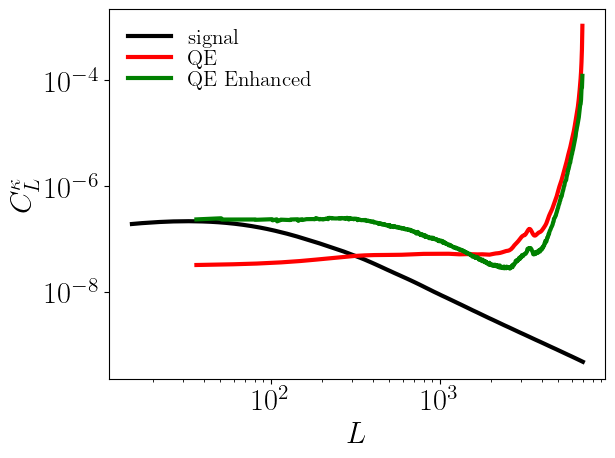

In [74]:
print("Plot noise power spectra")

fig, ax =plt.subplots(1)

ax.loglog(L, p2d_cmblens.fPinterp(L), 'k-', lw=3, label=r'signal')

Nq = fNqCmb_fft(L)
Nq_E = fNqCmb_fft_enhanced(L)

ax.loglog(L, Nq, c='r', lw=3, label=r'QE')
ax.loglog(L, Nq_E, c='g', lw=3, label=r'QE Enhanced')

ax.legend(loc=2, fontsize='x-small', labelspacing=0.1, frameon=False)
ax.set_xlabel(r'$L$')
ax.set_ylabel(r'$C_L^\kappa$')

fig.savefig('figures/QEvsQE_Enhanced.pdf', bbox_inches = "tight")